In [1]:
import os
os.environ["DISABLE_MPI"]="true"
from fgbias import setup_AAAA_recon, get_bias_terms, get_cl_smooth,dummy_teb, ClBinner
from falafel import utils as futils, qe
import numpy as np
from orphics import maps
import healpy as hp
from pixell import curvedsky
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
# Set some options for the lensing reconstruction

In [3]:
lmin = 100
lmax = 2000
mlmax = 2500

In [4]:
# Set noise level and beam (this will enter into to the Cinv filter used for lensing reconstruction)
# we're not actually going to add noise to the simulation here
noise_sigma = 5. #muK
beam_fwhm=1.5 #arcmin
ells = np.arange(mlmax+1)
beam = maps.gauss_beam(ells, beam_fwhm)
Nl_tt = (noise_sigma*np.pi/180./60.)**2./beam**2
nells = {"TT":Nl_tt, "EE":2*Nl_tt, "BB":2*Nl_tt}

#use falafel to get theory Cls 
ucls,tcls = futils.get_theory_dicts(grad=True, nells=nells, lmax=mlmax)

Get foreground bias estimates.

We need a few things:
- Foreground-only temperature alms. We could get these from a simulation but here 
I'm just going to create a simple simulation with point-sources.
- true lensing potential alms (use this to calculate primary bispectrum)
- Two versions of the same unlensed cmb realization, one lensed by the true lensing potential,
one lensed by some different lensing potential.

Generate point-source map and convert to alm

In [27]:
nside=2048
nsource=10000
flux=50. #mJY

#assing to random pixels 
npix = hp.nside2npix(nside)
flux_density_map = np.zeros(hp.nside2npix(nside))
pixel_area = hp.nside2pixarea(nside)
source_pix = np.random.choice(np.arange(npix),size=nsource)
np.add.at(flux_density_map, source_pix, flux/pixel_area)
#flux_density_map is in mJY per sr
#convert to CMB temp units
def flux_density_to_temp(freq):
    #get factor for converting delta flux density in MJy/sr
    #to delta T in CMB units. freq in GHz
    freq = float(freq)
    x = freq / 56.8
    return (1.05e3 * (np.exp(x)-1)**2 *
            np.exp(-x) * (freq / 100)**-4)

source_temp_map = (flux_density_map / 1.e9) * flux_density_to_temp(150.)

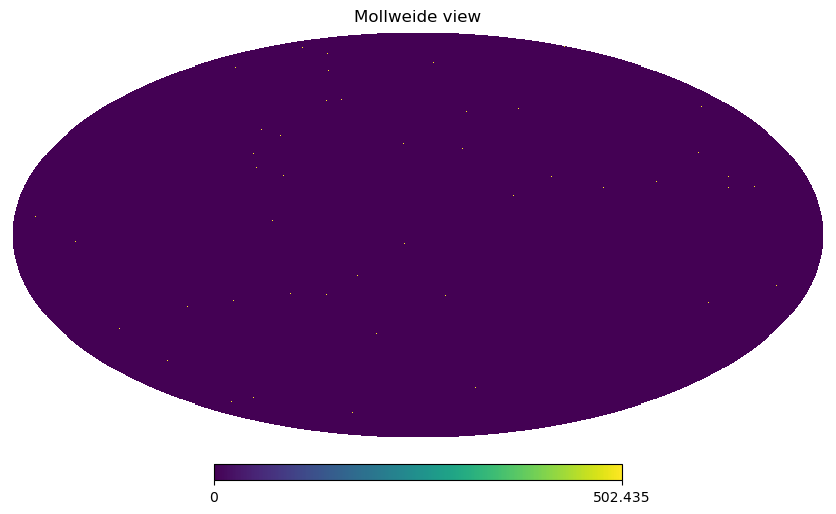

In [28]:
%matplotlib inline

hp.mollview(source_temp_map)

In [29]:
fg_alm = hp.map2alm(source_temp_map, lmax=mlmax)

In [24]:
kappa_alm = futils.change_alm_lmax(
    hp.read_alm("/global/cfs/projectdirs/act/data/maccrann/websky/kappa_alm_lmax6000.fits"),
    mlmax)
Ls = np.arange(mlmax+1)
phi_alm = curvedsky.almxfl( kappa_alm, 1./(Ls * (Ls+1) / 2) )

#cmb lensed by true kappa
cmb_alm = dummy_teb(
    hp.read_alm("/global/cfs/projectdirs/act/data/maccrann/websky/lensed_cmb/lensed_cmb_alm_websky_cmb1999_lmax6000.fits"),
)

#same cmb lensed by a different kappa
cmbp_alm = futils.get_cmb_alm(1999,0)

/tmp/ipykernel_1933196/2904268859.py:5: RuntimeWarning: divide by zero encountered in divide
  phi_alm = curvedsky.almxfl( kappa_alm, 1./(Ls * (Ls+1) / 2) )


Setup lensing reconstruction stuff. This generates `recon_setup`, a dictionary that contains various useful quantities functions, 
including those that perform lensing reconstruction using falafel.

In [25]:
px = qe.pixelization(nside=2048) #the pixelisation to use for the real-space quadratic estimator (shouldn't affect the result).
recon_setup = setup_AAAA_recon(px, lmin, lmax, mlmax,
                tcls,
                do_psh=True, do_prh=False,
                profile=None)

use new TT
 Response (TT)


Now use `get_bias_terms` to get the lensing foreground bias. This will take a few minutes I'm afraid. Sorry. 

In [22]:
bias_stuff = get_bias_terms(fg_alm, recon_setup, 
                   phi_alm, cmb_alm, cmbp_alm,
                   ests=["qe","psh"], comm=None)

getting biases for est: qe
doing fg-only reconstruction
qfunc: <function setup_AAAA_recon.<locals>.qfunc_tt_qe at 0x7f2a9eaa5a20>
doing secondary
getting biases for est: psh
doing fg-only reconstruction
qfunc: <function setup_AAAA_recon.<locals>.qfunc_tt_psh at 0x7f2a9d1b7910>
src_nonorm [-904487.73962372   -0.j            9867.28372642   +0.j
   27489.2216586    +0.j         ...    1967.78575782-5019.89502772j
    5645.35461056 +493.54044408j   -1031.56470375-4261.20801717j]
norm_src [0.00000000e+00 4.92401379e-12 4.93133865e-12 ... 4.50493532e-11
 4.50462005e-11 4.50426238e-11]
R_src_tt [ 0.00000000e+00 -3.74447874e+08 -1.12280869e+09 ...  1.75458643e+14
  1.75580748e+14  1.75703174e+14]
doing secondary
src_nonorm [-4973.78464601   -0.j         -3850.18058865   -0.j
  5632.43492377   +0.j         ...  1327.36103734-9521.28924681j
 -2833.72362037+1963.70724583j  1695.65153871-2278.02556485j]
norm_src [0.00000000e+00 4.92401379e-12 4.93133865e-12 ... 4.50493532e-11
 4.50462005e-11 4.50

`bias_stuff` is a dictionary containing the various outputs of `get_bias_terms`. 
Let's plot some of these outputs. We'll divide the total bias and each of the components by the theory $C_L^{\phi\phi}$

/tmp/ipykernel_1672551/2103312772.py:7: RuntimeWarning: invalid value encountered in divide
  cl_phiphi_binned = binner(ucls["kk"] / (Ls * (Ls+1) / 2)**2)


Text(0, 0.5, '$\\Delta C_L^{\\phi\\phi} / C_L^{\\phi\\phi}$')

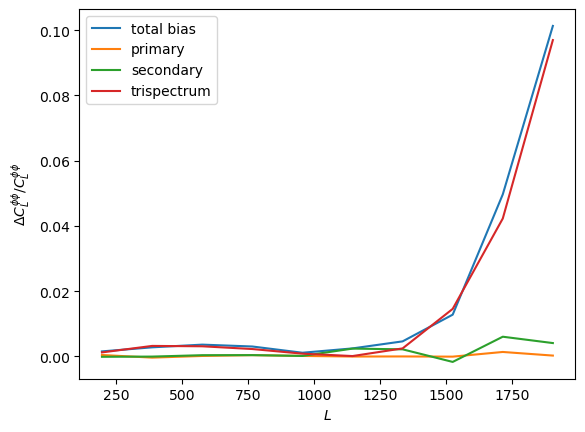

In [23]:
%matplotlib inline

binner = ClBinner(lmin=lmin, lmax=lmax, nbin=10)

est="qe"

cl_phiphi_binned = binner(ucls["kk"] / (Ls * (Ls+1) / 2)**2)

fig,ax=plt.subplots()
#ax.plot(binner.bin_mids, binner(bias_stuff["cl_phi"]), color="k", label=r"$C_L^{\phi\phi}$")
ax.plot(binner.bin_mids, binner(bias_stuff["total_%s"%est])/cl_phiphi_binned, "-", color="C0", label="total bias")
ax.plot(binner.bin_mids, binner(bias_stuff["primary_%s"%est])/cl_phiphi_binned, color="C1", label="primary")
ax.plot(binner.bin_mids, binner(bias_stuff["secondary_%s"%est])/cl_phiphi_binned, color="C2", label="secondary")
ax.plot(binner.bin_mids, binner(bias_stuff["trispectrum_%s"%est])/cl_phiphi_binned, color="C3", label="trispectrum")

#ax.set_yscale('symlog')
ax.legend()
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$\Delta C_L^{\phi\phi} / C_L^{\phi\phi}$")
        

## Compare qe (i.e. normal estimator) and point-source hardened estimators

Text(0, 0.5, '$\\Delta C_L^{\\phi\\phi} / C_L^{\\phi\\phi}$')

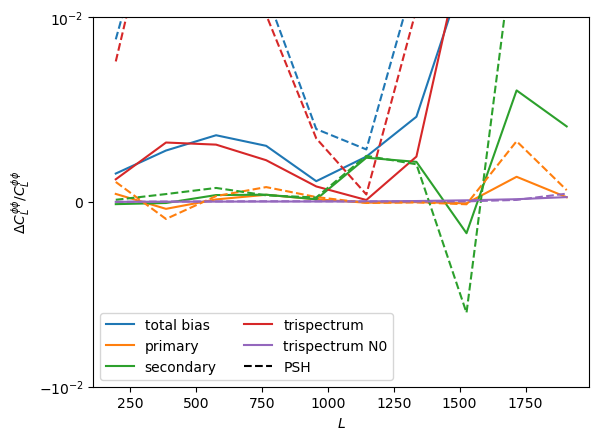

In [29]:
fig,ax=plt.subplots()

est, linestyle = "qe","-"
#ax.plot(binner.bin_mids, binner(bias_stuff["cl_phi"]), color="k", label=r"$C_L^{\phi\phi}$")
ax.plot(binner.bin_mids, binner(bias_stuff["total_%s"%est])/cl_phiphi_binned, linestyle, color="C0", label="total bias")
ax.plot(binner.bin_mids, binner(bias_stuff["primary_%s"%est])/cl_phiphi_binned, linestyle, color="C1", label="primary")
ax.plot(binner.bin_mids, binner(bias_stuff["secondary_%s"%est])/cl_phiphi_binned, linestyle, color="C2", label="secondary")
ax.plot(binner.bin_mids, binner(bias_stuff["trispectrum_%s"%est])/cl_phiphi_binned, linestyle, color="C3", label="trispectrum")
ax.plot(binner.bin_mids, binner(bias_stuff["tri_N0_%s"%est])/cl_phiphi_binned, linestyle,color="C4", label="trispectrum N0")

est, linestyle = "psh","--"
#ax.plot(binner.bin_mids, binner(bias_stuff["cl_phi"]), color="k", label=r"$C_L^{\phi\phi}$")
ax.plot(binner.bin_mids, binner(bias_stuff["total_%s"%est])/cl_phiphi_binned, linestyle, color="C0",)# label="total bias")
ax.plot(binner.bin_mids, binner(bias_stuff["primary_%s"%est])/cl_phiphi_binned, linestyle,color="C1",) # label="primary")
ax.plot(binner.bin_mids, binner(bias_stuff["secondary_%s"%est])/cl_phiphi_binned, linestyle,color="C2",)# label="secondary")
ax.plot(binner.bin_mids, binner(bias_stuff["trispectrum_%s"%est])/cl_phiphi_binned, linestyle,color="C3",)# label="trispectrum")
ax.plot(binner.bin_mids, binner(bias_stuff["tri_N0_%s"%est])/cl_phiphi_binned, linestyle,color="C4",)# label="trispectrum")
ax.plot([],[],'k--',label="PSH")

ax.set_ylim([-0.01,0.01])
ax.set_yscale('symlog')
ax.legend(ncols=2)
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$\Delta C_L^{\phi\phi} / C_L^{\phi\phi}$")
        

In [31]:
fg_alm_filtered = recon_setup["filter"](fg_alm)

In [32]:
phi_nonorm = qe.qe_all(px, ucls, mlmax,
                        fTalm=fg_alm_filtered[0], fEalm=None,fBalm=None,
                        estimators=['TT'],
                        xfTalm=fg_alm_filtered[0], xfEalm=None,xfBalm=None)['TT']

In [ ]:
import pytempura
src_nonorm = qe.qe_source(px, mlmax, fg_alm_filtered[0],
                          xfTalm=fg_alm_filtered[0])

In [40]:
R_tt_src = pytempura.get_cross(
    'TT','SRC',ucls,tcls,lmin,lmax,
    k_ellmax=mlmax)
print(R_tt_src)
R_src_tt = pytempura.get_cross(
    'SRC','TT',ucls,tcls,lmin,lmax,
    k_ellmax=mlmax)
print(R_src_tt)
norm_src = pytempura.get_norms(
        ['src'], ucls, ucls, tcls,
        lmin, lmax,
        k_ellmax=mlmax)['src']
print(norm_src)

 Response (TT)
[ 0.00000000e+00 -3.74447874e+08 -1.12280869e+09 ...  1.75458643e+14
  1.75580748e+14  1.75703174e+14]
 Response (TT)
[ 0.00000000e+00 -3.74447874e+08 -1.12280869e+09 ...  1.75458643e+14
  1.75580748e+14  1.75703174e+14]
[0.00000000e+00 4.92401379e-12 4.93133865e-12 ... 4.50493532e-11
 4.50462005e-11 4.50426238e-11]


In [34]:
print(R_src_tt[None])

[[ 0.00000000e+00 -3.74447874e+08 -1.12280869e+09 ...  1.75458643e+14
   1.75580748e+14  1.75703174e+14]]


In [35]:
norm_lens = recon_setup["norms"]["TT"]

In [36]:
#we should be able to relate phi_nonorm to src_nonorm via the repsonse and norm factors 
phi = curvedsky.almxfl(phi_nonorm[0], norm_lens[0])
phi_from_src = curvedsky.almxfl(src_nonorm, norm_lens[0] * norm_src * R_src_tt)

phi_bh_nonorm = phi - phi_from_src
norm = 1./(1. - norm_lens[0] * norm_src * R_src_tt**2.)
phi_bh = curvedsky.almxfl(phi_bh_nonorm, norm)

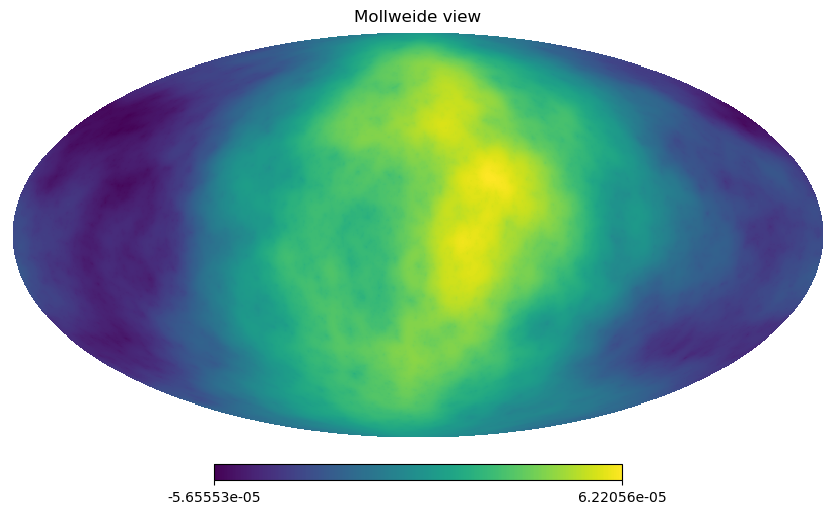

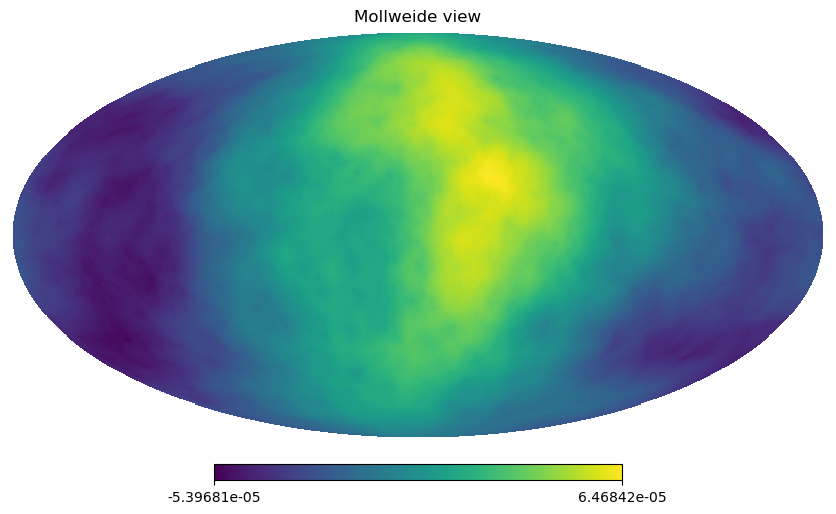

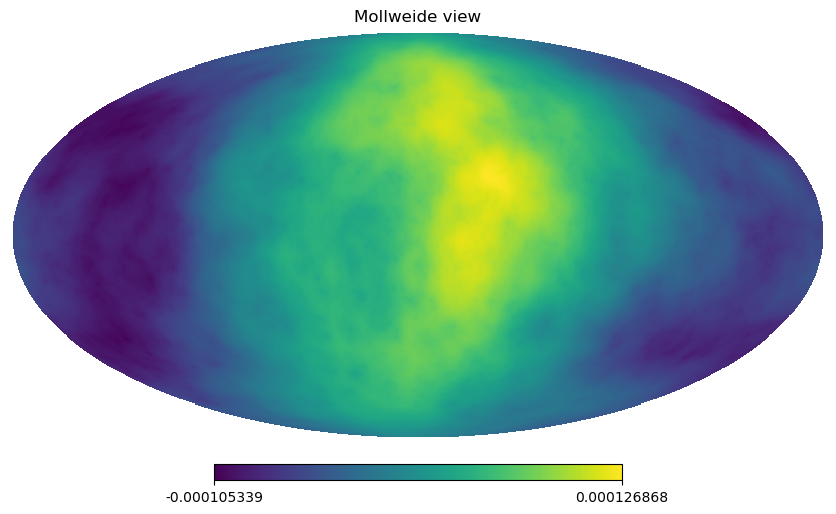

In [37]:
%matplotlib inline

hp.mollview(hp.alm2map(phi, nside=1024))
hp.mollview(hp.alm2map(phi_from_src, nside=1024))
hp.mollview(hp.alm2map(phi_bh_nonorm, nside=1024))

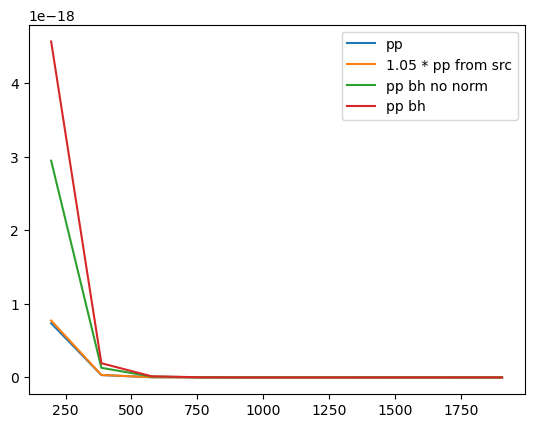

In [21]:
%matplotlib inline

fig,ax=plt.subplots()
binner = ClBinner(lmin=lmin, lmax=lmax, nbin=10)
cl_pp = curvedsky.alm2cl(phi)
cl_pp_form_src = curvedsky.alm2cl(phi_from_src)
cl_bh = curvedsky.alm2cl(phi_bh)
cl_bh_nonorm = curvedsky.alm2cl(phi_bh_nonorm)

#N0_pp = recon_setup["


ax.plot(binner.bin_mids, binner(cl_pp), label="pp")
ax.plot(binner.bin_mids, 1.05*binner(cl_pp_form_src), label="1.05 * pp from src")
ax.plot(binner.bin_mids, binner(cl_bh_nonorm), label="pp bh no norm")
ax.plot(binner.bin_mids, binner(cl_bh), label="pp bh")

ax.legend()


As a brief aside - can just check our lensing reconstruction is working on one of the (noiseless)
lensed CMBs. Will need to re-compute the N0 since there's no noise

In [ ]:
#filter cmb alm - the setup function sets up the appropriate Cinv filter
cmb_alm_filtered = recon_setup["filter"](
    futils.change_alm_lmax(cmb_alm, mlmax))
#do reconstruction, element 0 is the gradient leg 
phi_recon = recon_setup["qfunc_tt_qe"](cmb_alm_filtered[0], cmb_alm_filtered[0])[0] 
cl_phiphi_raw = curvedsky.alm2cl(phi_recon)
#Need to recompute N0 since we don't have instrumental noise
N0_nonoise = recon_setup["get_fg_trispectrum_phi_N0_qe"]((cl_tt_nonoise)[:mlmax+1])[0]
cl_phiphi = cl_phiphi_raw - N0_nonoise
cl_phiphi_theory = ucls["kk"] / (Ls * (Ls+1) / 2)**2

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()

binner = ClBinner(lmin=lmin, lmax=lmax, nbin=10)

ax.plot(binner.bin_mids, binner(cl_phiphi_raw))
ax.plot(binner.bin_mids, binner(cl_phiphi_raw-N0_nonoise[0]), label=r"reconstructed $C_L^{\phi\phi}$")
ax.plot(binner.bin_mids, binner(cl_phiphi_theory), label=r"theory $C_L^{\phi\phi}$")

ax.plot(binner.bin_mids, binner(cl_phiphi_raw-N0_nonoise[0]) / binner(cl_phiphi_theory) -1 )

ax.set_yscale('log')